# Load libraries

### Make sure external libraries are installed

In [157]:
%%sh
pip install biopython pandas seaborn tqdm

### Load what we need

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from pathlib import Path

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import *

# Open files

In [75]:
working_dir = Path("/Users/regevschweiger/git/practical/")

In [76]:
aln = AlignIO.read(working_dir / "iqtree-2.2.2.6-example.phy", format="phylip")

# Calculate the distance matrix

In [104]:
def view_distance_matrix(distance_matrix):
    n_names = len(distance_matrix)
    D = np.zeros((n_names, n_names))
    for i in range(n_names):
        D[i,:i+1] = distance_matrix.matrix[i]
    names = np.array(distance_matrix.names).astype(str)
    df = pd.DataFrame(data=D, index=names, columns=names)
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(df, vmin=0, square=True, ax=ax)
    ax.set_title("Distance matrix")

In [158]:
print(DistanceCalculator.dna_models)

['benner22', 'benner6', 'benner74', 'blastn', 'dayhoff', 'feng', 'genetic', 'gonnet1992', 'hoxd70', 'johnson', 'jones', 'levin', 'mclachlan', 'mdm78', 'megablast', 'blastn', 'rao', 'risler', 'schneider', 'str', 'trans']


In [102]:
# For other DNA model options: print(DistanceCalculator.dna_models)
distance_matrix = DistanceCalculator('identity').get_distance(aln)

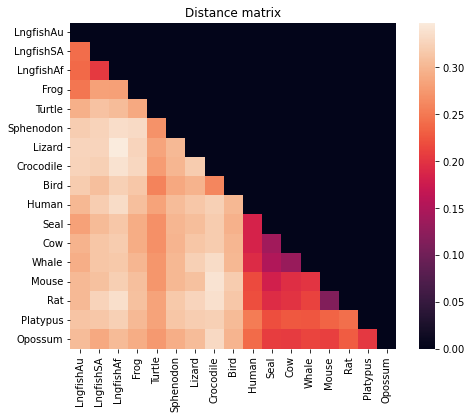

In [105]:
view_distance_matrix(distance_matrix)


# Build a tree

## Neighbor joining

In [111]:
NJ_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), "nj")

In [119]:
NJ_tree = NJ_constructor.build_tree(aln)

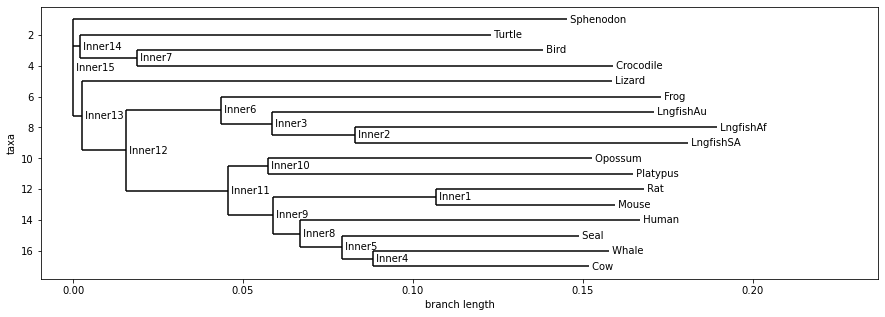

In [125]:
# Possible: NJ_tree.ladderize()
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(NJ_tree, axes=ax)

## UPGMA

In [127]:
UPGMA_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), 'upgma')

In [129]:
UPGMA_tree = UPGMA_constructor.build_tree(aln)

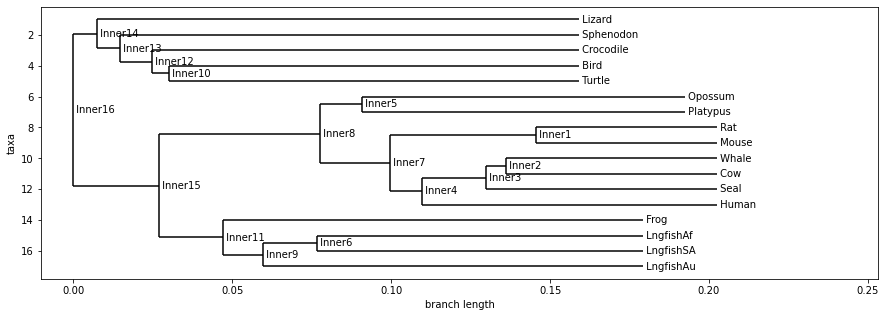

In [130]:
# Possible: NJ_tree.ladderize()
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(UPGMA_tree, axes=ax)

# Bootstrapping

In [132]:
bootstrap_alns = list(bootstrap(aln, 10))

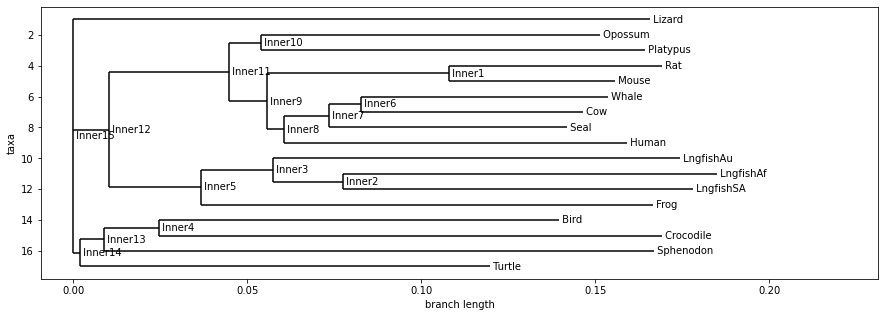

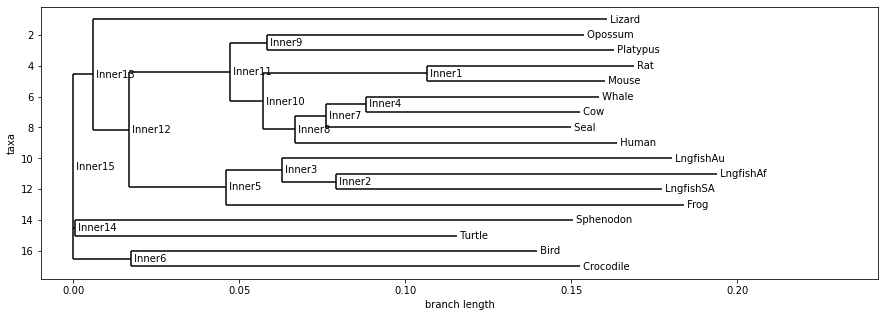

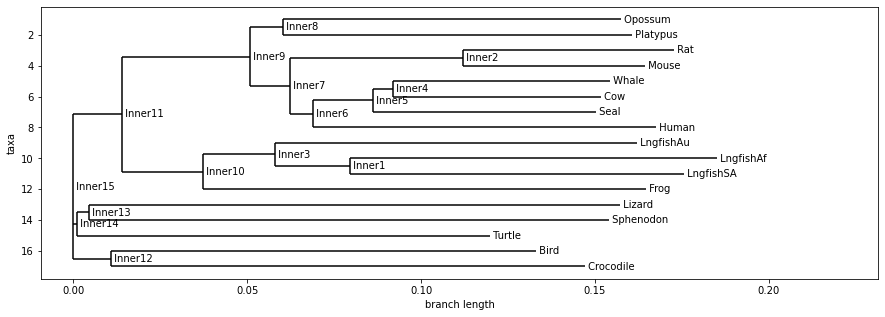

In [161]:
for bootstrap_aln in bootstrap_alns[:3]:
    fig, ax = plt.subplots(figsize=(15,5))
    Phylo.draw(NJ_constructor.build_tree(bootstrap_aln), axes=ax)


### Build on a shorter segment

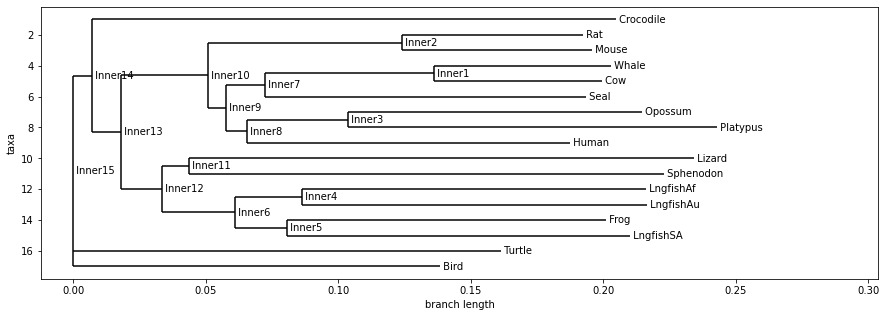

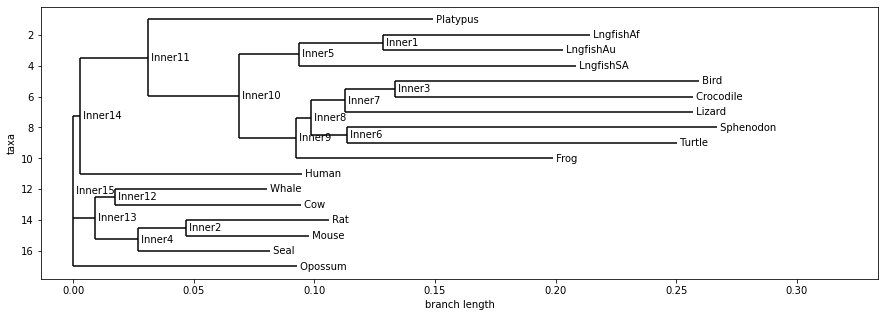

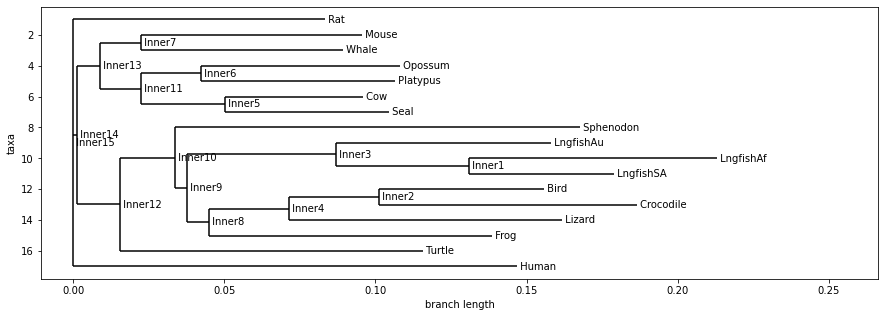

In [162]:
for bootstrap_aln in bootstrap_alns[:3]:
    shorter_aln = bootstrap_aln[:, :100]
    
    fig, ax = plt.subplots(figsize=(15,5))
    Phylo.draw(NJ_constructor.build_tree(shorter_aln), axes=ax)


# Consensus trees and confidence

In [156]:
bootstrap_trees = [UPGMA_constructor.build_tree(bootstrap_aln) for bootstrap_aln in bootstrap(aln, 100)]

In [154]:
maj_tree = majority_consensus(bootstrap_trees)

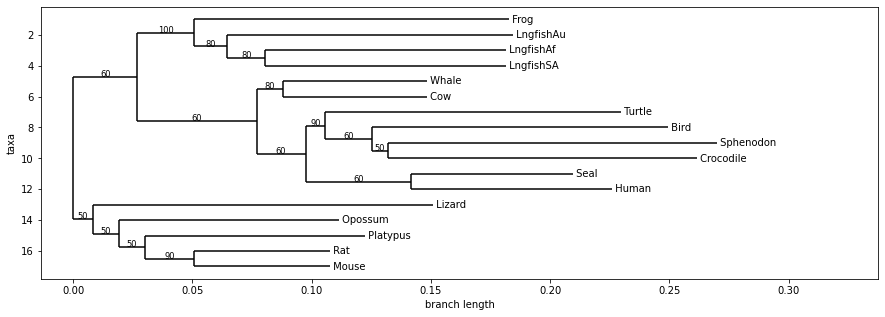

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(maj_tree, axes=ax)